In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

df_siec = pd.read_csv("df_siec.csv")
    
agregados = ["EU27_2020", "EU28", "EA19", "EA20", "EA", "EFTA", "EU15", "EU25", "EU27"]
df_siec = df_siec[~df_siec["geo"].isin(agregados)].copy()

exclude_cols = ["geo", "TIME_PERIOD", "PIB_growth_pct"]
siec_cols = [c for c in df_siec.columns if c not in exclude_cols]

df_siec_log = df_siec.copy()
df_siec_log[siec_cols] = df_siec_log[siec_cols].clip(lower=0)
df_siec_log[siec_cols] = np.log1p(df_siec_log[siec_cols])

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

X = StandardScaler().fit_transform(df_siec_log[siec_cols].fillna(0))

pca = PCA(n_components=14)
X_pca = pca.fit_transform(X)

for i in range(14):
    df_siec_log[f"PC{i+1}"] = X_pca[:, i]

loadings = pd.DataFrame(
    pca.components_.T,
    index=siec_cols,
    columns=[f"PC{i+1}" for i in range(14)]
)

print("Explained variance per component (%):")
print(np.round(pca.explained_variance_ratio_ * 100, 2))
print("\nTotal cumulative explained variance: {:.2f}%".format(pca.explained_variance_ratio_.sum() * 100))

for i in range(14):
    pc = f"PC{i+1}"
    print(f"\n=== {pc} (explains {pca.explained_variance_ratio_[i]*100:.2f}% of variance) ===")
    print("Top positive loadings:")
    print(loadings[pc].sort_values(ascending=False).head(5))
    print("Top negative loadings:")
    print(loadings[pc].sort_values(ascending=True).head(5))

Varianza explicada por componente (%):
[29.63 11.98  6.64  6.02  4.42  4.05  3.68  3.36  3.01  2.03  1.86  1.73
  1.5   1.34]

Varianza acumulada total: 81.25%

=== PC1 (explica 29.63% de la varianza) ===
Top +: GEP_Bioenergía         0.144065
DL_Bioenergía          0.143896
DL_total               0.136988
FC_IND_E_Bioenergía    0.136450
FC_E_Nuclear           0.136238
Name: PC1, dtype: float64
Top -: FC_IND_E_Renovables_total     -0.018662
FC_E_Renovables_total         -0.018662
GEP_MAPCHP_Renovables_total   -0.017120
GHP_Renovables_total          -0.016665
GHP_MAPCHP_Renovables_total   -0.016645
Name: PC1, dtype: float64

=== PC2 (explica 11.98% de la varianza) ===
Top +: TRANS_CAR             0.135737
TRANS_BUS_TOT         0.128392
TRANS_SEAV            0.127091
TRANS_AC              0.126607
GEP_MAPCHP_Nuclear    0.109014
Name: PC2, dtype: float64
Top -: GEP_Gas        -0.208473
FC_OTH_E_Gas   -0.206154
FC_E_Gas       -0.203362
GEP_MAPE_Gas   -0.196694
AFC_Gas        -0.194627
Name

C:\Users\joelm\AppData\Local\Temp\ipykernel_18520\2391797580.py:15: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\joelm\AppData\Local\Temp\ipykernel_18520\2391797580.py:15: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\joelm\AppData\Local\Temp\ipykernel_18520\2391797580.py:15: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragment

In [ ]:
var_exp = pca.explained_variance_ratio_

grupos = {
    "energia": [0, 3],
    "transporte": [1, 9, 11, 13],
    "renovables": [2, 4, 5, 8],
    "emisiones": [7],
    "economia": [6, 10, 12]
}

for nombre, idx in grupos.items():
    cols = [f"PC{i+1}" for i in idx]
    pesos = pd.Series(var_exp[idx] / var_exp[idx].sum(), index=cols)
    df_siec_log[f"PC_macro_{nombre}"] = df_siec_log[cols].mul(pesos, axis=1).sum(axis=1)


C:\Users\joelm\AppData\Local\Temp\ipykernel_18520\913777872.py:15: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\joelm\AppData\Local\Temp\ipykernel_18520\913777872.py:15: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`

C:\Users\joelm\AppData\Local\Temp\ipykernel_18520\913777872.py:15: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented 

In [ ]:
from linearmodels.panel import PanelOLS
import statsmodels.api as sm
import pandas as pd
import numpy as np

df_siec_log_filtered = df_siec_log.dropna(subset=['PIB_real_MEUR'])

componentes = [f"PC{i+1}" for i in range(14)]

var_exp = pca.explained_variance_ratio_

df_weighted = df_siec_log_filtered[componentes].copy()

for i, col in enumerate(df_weighted.columns):
    df_weighted[col] = df_weighted[col] * var_exp[i]

df_weighted['geo'] = df_siec_log_filtered['geo']
df_weighted['TIME_PERIOD'] = df_siec_log_filtered['TIME_PERIOD']

df_siec_log_filtered = df_siec_log_filtered.set_index(['geo', 'TIME_PERIOD'])
df_weighted = df_weighted.set_index(['geo', 'TIME_PERIOD'])

y = df_siec_log_filtered['PIB_real_MEUR']
X = df_weighted

X = X.loc[y.index]

X = sm.add_constant(X)

model = PanelOLS(y, X, entity_effects=True).fit()

print(model.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:          PIB_real_MEUR   R-squared:                        0.7107
Estimator:                   PanelOLS   R-squared (Between):              0.5569
No. Observations:                1025   R-squared (Within):               0.7107
Date:                Mon, Nov 10 2025   R-squared (Overall):              0.5611
Time:                        10:04:32   Log-likelihood                    685.99
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      170.90
Entities:                          37   P-value                           0.0000
Avg Obs:                       27.703   Distribution:                  F(14,974)
Min Obs:                      10.0000                                           
Max Obs:                       34.000   F-statistic (robust):             170.90
                            

In [ ]:
from linearmodels.panel import PanelOLS
import pandas as pd
import numpy as np

df_filtered = df_siec_log.dropna(subset=['PIB_real_MEUR']).copy()

components = [f"PC{i+1}" for i in range(14)]
var_exp = pca.explained_variance_ratio_

df_weighted = df_filtered[components].copy()
for i, col in enumerate(components):
    df_weighted[col] = df_weighted[col] * var_exp[i]

df_weighted["geo"] = df_filtered["geo"]
df_weighted["TIME_PERIOD"] = df_filtered["TIME_PERIOD"]

df_lagged = (
    df_weighted.groupby("geo")[components]
    .shift(5)
    .add_suffix("_lag5")
)
df_lagged["geo"] = df_filtered["geo"]
df_lagged["TIME_PERIOD"] = df_filtered["TIME_PERIOD"]

df_filtered = df_filtered.set_index(["geo", "TIME_PERIOD"])
df_weighted = df_weighted.set_index(["geo", "TIME_PERIOD"])
df_lagged = df_lagged.set_index(["geo", "TIME_PERIOD"])

y = df_filtered["PIB_real_MEUR"]
X = df_weighted[components].join(df_lagged.drop(columns=["geo", "TIME_PERIOD"], errors="ignore"), how="inner")

y, X = y.align(X, join="inner")

model = PanelOLS(
    dependent=y,
    exog=X,
    entity_effects=True
).fit(cov_type="clustered", cluster_entity=True)

print(model.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:          PIB_real_MEUR   R-squared:                        0.7245
Estimator:                   PanelOLS   R-squared (Between):              0.0179
No. Observations:                 840   R-squared (Within):               0.7245
Date:                Mon, Nov 10 2025   R-squared (Overall):              0.0285
Time:                        10:04:33   Log-likelihood                    805.61
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      72.801
Entities:                          37   P-value                           0.0000
Avg Obs:                       22.703   Distribution:                  F(28,775)
Min Obs:                       5.0000                                           
Max Obs:                       29.000   F-statistic (robust):             93.657
                            

C:\Users\joelm\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\linearmodels\panel\model.py:1258: MissingValueWarning:


Inputs contain missing values. Dropping rows with missing observations.




=== Clusters para el año 2000 ===
cluster
0    [AL, BG, CY, DE, EL, HR, IE, IS, LT, LV, MK, P...
1                         [AT, BE, ES, IT, LU, MT, SK]
2                     [CZ, DK, FI, FR, HU, NL, NO, SE]
3                                                 [EE]
Name: geo, dtype: object


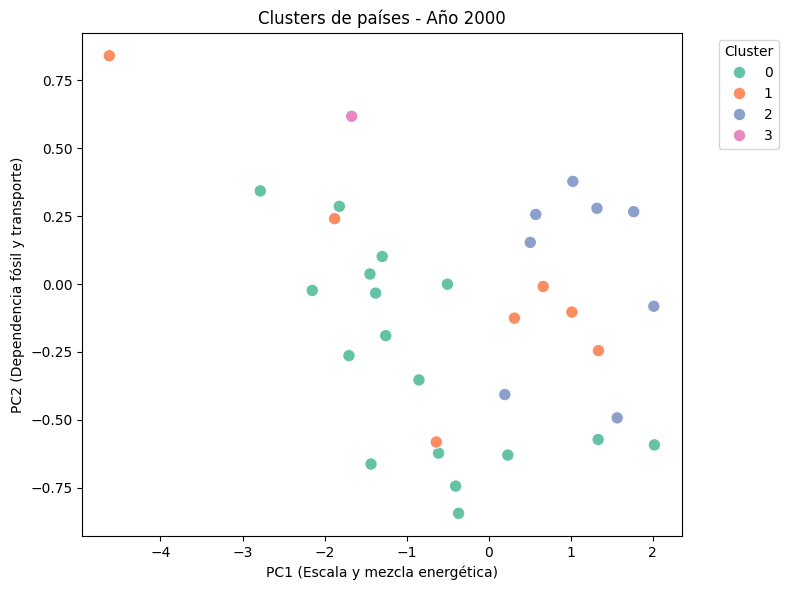


=== Clusters para el año 2010 ===
cluster
0    [BG, CY, DK, EL, ES, FI, FR, HR, IE, LT, LU, L...
1                                 [AT, BE, HU, IT, SE]
2     [AL, CZ, DE, IS, ME, MK, RO, RS, SK, TR, UA, XK]
3                                                 [EE]
Name: geo, dtype: object


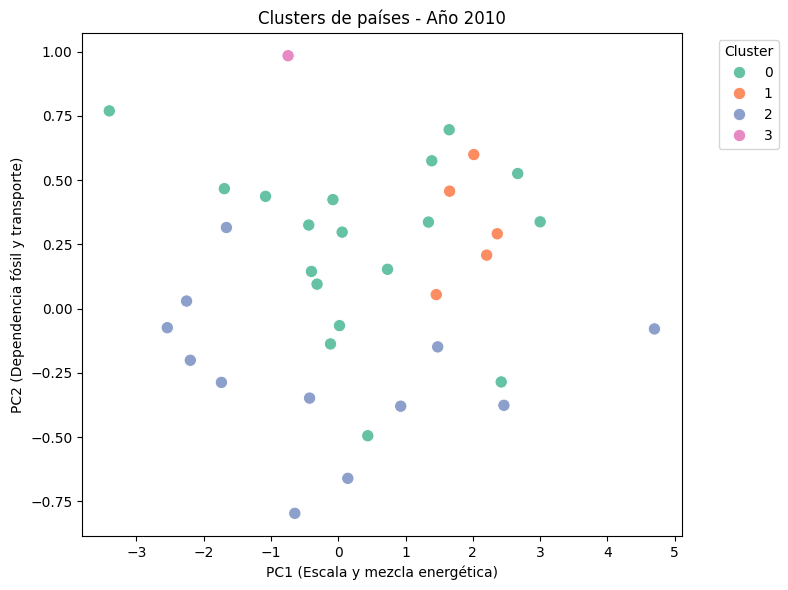


=== Clusters para el año 2020 ===
cluster
0         [AL, BA, CZ, HU, IS, ME, MK, RS, TR, UA, XK]
1    [AT, CY, DK, EE, EL, ES, FI, FR, HR, IE, IT, L...
2                                             [BG, DE]
3                                                 [BE]
Name: geo, dtype: object


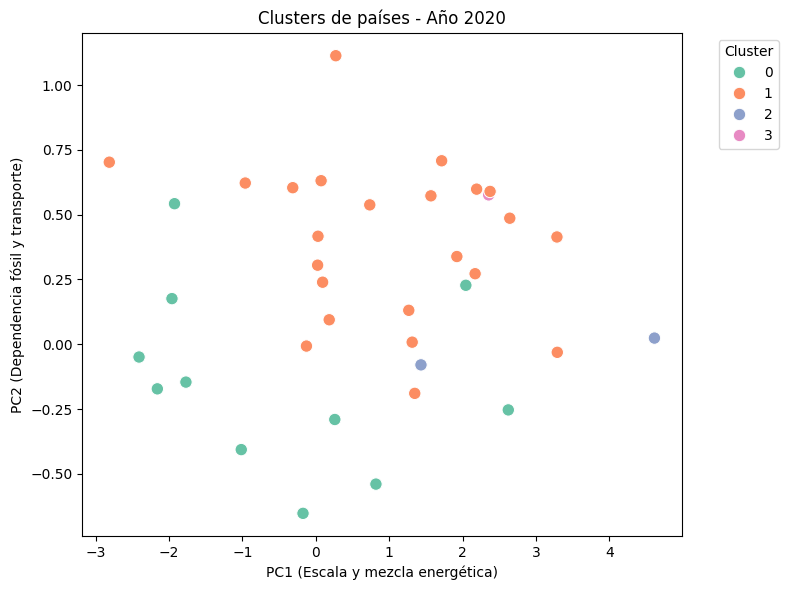


=== Países que cambiaron de grupo ===
   geo  cluster_2000  cluster_2010  cluster_2020  cambio
0   AL             0             2             0    True
2   BE             1             1             3    True
3   BG             0             0             2    True
4   CY             0             0             1    True
5   CZ             2             2             0    True
6   DE             0             2             2    True
7   DK             2             0             1    True
8   EE             3             3             1    True
9   EL             0             0             1    True
10  ES             1             0             1    True
11  FI             2             0             1    True
12  FR             2             0             1    True
13  HR             0             0             1    True
14  HU             2             1             0    True
15  IE             0             0             1    True
16  IS             0             2             0 

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import pandas as pd

components = [f"PC{i+1}" for i in range(14)]
key_years = [2000, 2010, 2020]
K = 4

df_clusters = df_siec_log_weighted_filtered.reset_index()
df_clusters_periods = df_clusters[df_clusters["TIME_PERIOD"].isin(key_years)].copy()

cluster_results = {}

for year in key_years:
    data_year = df_clusters_periods[df_clusters_periods["TIME_PERIOD"] == year].copy()
    X = data_year[components]
    X_scaled = StandardScaler().fit_transform(X)

    kmeans = KMeans(n_clusters=K, random_state=42, n_init=50)
    data_year["cluster"] = kmeans.fit_predict(X_scaled)

    cluster_results[year] = data_year[["geo", "cluster"]]

    print(f"\n=== Clusters for year {year} ===")
    print(data_year.groupby("cluster")["geo"].agg(list))

    plt.figure(figsize=(8,6))
    sns.scatterplot(
        data=data_year, x="PC1", y="PC2",
        hue="cluster", palette="Set2", s=80
    )
    plt.title(f"Country Clusters - Year {year}")
    plt.xlabel("PC1 (Energy scale and mix)")
    plt.ylabel("PC2 (Fossil dependency and transport)")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

df_evolution = (
    cluster_results[key_years[0]]
    .merge(cluster_results[key_years[1]], on="geo", suffixes=("_2000", "_2010"))
    .merge(cluster_results[key_years[2]], on="geo")
    .rename(columns={"cluster": "cluster_2020"})
)

df_evolution["changed"] = (
    (df_evolution["cluster_2000"] != df_evolution["cluster_2010"]) |
    (df_evolution["cluster_2010"] != df_evolution["cluster_2020"])
)
print("\n=== Countries that changed cluster ===")
print(df_evolution[df_evolution["changed"]][["geo", "cluster_2000", "cluster_2010", "cluster_2020"]])

labels = [f"{y} - C{i}" for y in key_years for i in range(K)]
sources, targets, values = [], [], []

for i in range(len(key_years) - 1):
    temp = cluster_results[key_years[i]].merge(
        cluster_results[key_years[i + 1]], on="geo", suffixes=("_src", "_dst")
    )
    counts = temp.groupby(["cluster_src", "cluster_dst"]).size().reset_index(name="count")
    for _, row in counts.iterrows():
        sources.append(row["cluster_src"] + K * i)
        targets.append(row["cluster_dst"] + K * (i + 1))
        values.append(row["count"])

fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=20,
        thickness=15,
        line=dict(color="black", width=0.5),
        label=labels,
        color=["#66c2a5","#fc8d62","#8da0cb","#e78ac3"] * len(key_years)
    ),
    link=dict(
        source=sources,
        target=targets,
        value=values,
        color="rgba(160,160,160,0.4)"
    )
)])
fig.update_layout(
    title_text="Evolution of Energy-Economic Clusters (2000 to 2010 to 2020)",
    font=dict(size=12),
    height=500
)
fig.show()